In [3]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import datetime

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
full_data = pd.read_csv('../data/curated_data.csv')

# Original

## Train Test Split

In [5]:
date = sorted(list(set(full_data['date'])))

In [6]:
train_dates = date[:175]
val_dates = date[175:175+37]
test_dates = date[175+37:]

In [7]:
train_data = full_data[full_data['date'].isin(train_dates)]
val_data = full_data[full_data['date'].isin(val_dates)]
test_data = full_data[full_data['date'].isin(test_dates)]

In [8]:
train_data

,date,stock,closePrice,ret,log_ret
0,2023-01-02,0,59.99,0.997008,-0.002996
1,2023-01-03,0,59.66,0.994499,-0.005516
2,2023-01-04,0,59.38,0.995307,-0.004704
3,2023-01-05,0,59.21,0.997137,-0.002867
4,2023-01-06,0,59.09,0.997973,-0.002029
...,...,...,...,...,...
12371,2023-06-21,49,44.15,0.987254,-0.012828
12372,2023-06-22,49,44.51,1.008154,0.008121
12373,2023-06-23,49,44.21,0.993260,-0.006763
12374,2023-06-24,49,44.23,1.000452,0.000452


In [9]:
val_data

,date,stock,closePrice,ret,log_ret
175,2023-06-26,0,61.16,1.007910,0.007879
176,2023-06-27,0,61.66,1.008175,0.008142
177,2023-06-28,0,62.22,1.009082,0.009041
178,2023-06-29,0,62.43,1.003375,0.003369
179,2023-06-30,0,62.31,0.998078,-0.001924
...,...,...,...,...,...
12408,2023-07-28,49,43.08,0.998378,-0.001624
12409,2023-07-29,49,42.44,0.985144,-0.014968
12410,2023-07-30,49,41.88,0.986805,-0.013283
12411,2023-07-31,49,42.39,1.012178,0.012104


In [10]:
test_data

,date,stock,closePrice,ret,log_ret
212,2023-08-02,0,63.67,1.002993,0.002989
213,2023-08-03,0,63.64,0.999529,-0.000471
214,2023-08-04,0,63.82,1.002828,0.002824
215,2023-08-05,0,63.89,1.001097,0.001096
216,2023-08-06,0,63.52,0.994209,-0.005808
...,...,...,...,...,...
12445,2023-09-03,49,43.02,0.994682,-0.005332
12446,2023-09-04,49,43.03,1.000232,0.000232
12447,2023-09-05,49,43.57,1.012549,0.012471
12448,2023-09-06,49,43.13,0.989901,-0.010150


### Prophet

In [11]:
train_data = train_data.rename({'ret':'y', 'date':'ds'}, axis = 1)
val_data = val_data.rename({'ret':'y', 'date':'ds'}, axis = 1)

In [12]:
class Prophet_hackathon:

    def __init__(self, weekly_seasonality, seasonality_mode, changepoint_prior_scale, seasonality_prior_scale,
                monthly_seasonality, quarterly_seasonality, **kwargs):

        self.weekly_seasonality = weekly_seasonality
        self.seasonality_mode = seasonality_mode
        self.changepoint_prior_scale = changepoint_prior_scale
        self.seasonality_prior_scale = seasonality_prior_scale
        self.monthly_seasonality = monthly_seasonality
        self.quarterly_seasonality = quarterly_seasonality
        

        self.stocks = []
        self.train_obs = []
        self.train_pred = []
        self.val_obs = []
        self.val_pred = []


    def fit(self, train_y, val_y):


        for stock in set(train_y['stock']):

            this_stock_train = train_y[train_y['stock'] == stock]
            this_stock_val = val_y[val_y['stock'] == stock]

            len_train = len(this_stock_train)
            len_val = len(this_stock_val)

            this_stock_train.index = range(len_train)
            this_stock_val.index = range(len_val)

            model = Prophet(weekly_seasonality=self.weekly_seasonality,
                seasonality_mode = self.seasonality_mode,
                changepoint_prior_scale=self.changepoint_prior_scale,
                seasonality_prior_scale=self.seasonality_prior_scale,
                yearly_seasonality='auto')
            
            if self.monthly_seasonality:
                model.add_seasonality(name='monthly', period=30.5, fourier_order = 5, mode=self.seasonality_mode)
            
            if self.quarterly_seasonality:
                model.add_seasonality(name='quarterly', period=91.25, fourier_order = 8, mode=self.seasonality_mode)

            model.fit(this_stock_train[['y', 'ds']])

            self.stocks.append(stock)

            future = model.make_future_dataframe(periods=len_val, freq='D')[len_train:]

            stock_train_obs = this_stock_train.loc[:]['y']
            stock_train_pred = model.predict(this_stock_train[['ds']]).loc[:]['yhat']
            
            stock_val_obs = this_stock_val.loc[:]['y']
            stock_val_pred = model.predict(future).loc[:]['yhat']

            self.train_obs.extend(stock_train_obs)
            self.train_pred.extend(stock_train_pred)
            self.val_obs.extend(stock_val_obs)
            self.val_pred.extend(stock_val_pred)

            

    def predict(self, mode):

        if mode == 'train':
            return self.train_obs, self.train_pred


        elif mode == 'val':
            return self.val_obs, self.val_pred

In [11]:
import pandas as pd
import copy
import time
import numpy as np
import pickle

from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score





class JiaoCheng:



    def __init__(self):
        """ Initialise class """
        self._initialise_objects()

        print('JiaoCheng Initialised')



    def _initialise_objects(self):
        """ Helper to initialise objects """

        self.train_x = None
        self.train_y = None
        self.val_x = None
        self.val_y = None
        self.test_x = None
        self.test_y = None
        self.tuning_result = None
        self.model = None
        self.parameter_choices = None
        self.hyperparameters = None
        self.feature_n_ningxiang_score_dict = None
        self.non_tuneable_parameter_choices = list()
        self._feature_combo_n_index_map = None
        self.checked = None
        self.result = None
        self.tuning_result_saving_address = None
        self.object_saving_address = None
        self._up_to = 0
        self._tune_features = False
        self._seed = 19210216
        self.best_score = -np.inf
        self.best_combo = None
        self.best_clf = None
        self.clf_type = None
        self.combos = None
        self.n_items = None
        self.hyperparameter_tuning_order = None
        self._tuning_order_map_hp = None
        self._parameter_value_map_index = None
        self._total_combos = None
        self._tune_features = False
        self.hyperparameter_default_values = None
        self.best_model_saving_address = None

        self.regression_extra_output_columns = ['Train r2', 'Val r2', 'Test r2', 
            'Train RMSE', 'Val RMSE', 'Test RMSE', 'Train MAPE', 'Val MAPE', 'Test MAPE', 'Time']
        self.classification_extra_output_columns = ['Train accu', 'Val accu', 'Test accu', 
            'Train balanced_accu', 'Val balanced_accu', 'Test balanced_accu', 'Train f1', 'Val f1', 'Test f1', 
            'Train precision', 'Val precision', 'Test precision', 'Train recall', 'Val recall', 'Test recall', 'Time']

        

    def read_in_data(self, train_y, val_y):
        """ Reads in train validate test data for tuning """

        self.train_y = train_y
        self.val_y = val_y
        print("Read in Train y data")



    def read_in_model(self, model, type):
        """ Reads in underlying model object for tuning, and also read in what type of model it is """

        assert type == 'Classification' or type == 'Regression' # check

        # record
        self.model = model
        self.clf_type = type 

        print(f'Successfully read in model {self.model}, which is a {self.clf_type} model')



    def set_hyperparameters(self, parameter_choices):
        """ Input hyperparameter choices """

        self.parameter_choices = parameter_choices
        self._sort_hyperparameter_choices()

        self.param_value_reverse_map = {param:{self.parameter_choices[param][j]:j for j in range(len(self.parameter_choices[param]))} for param in self.parameter_choices}

        self.hyperparameters = list(parameter_choices.keys())

        # automatically calculate how many different values in each hyperparameter
        self.n_items = [len(parameter_choices[key]) for key in self.hyperparameters]
        self._total_combos = np.prod(self.n_items)

        # automatically calculate all combinations and setup checked and result arrays and tuning result dataframe
        self._get_combinations()
        self._get_checked_and_result_array()
        self._setup_tuning_result_df()

        print("Successfully recorded hyperparameter choices")



    def _sort_hyperparameter_choices(self):
        """ Helper to ensure all hyperparameter choice values are in order from lowest to highest """

        for key in self.parameter_choices:
            tmp = copy.deepcopy(list(self.parameter_choices[key]))
            tmp.sort()
            self.parameter_choices[key] = tuple(tmp)

    

    def _get_combinations(self):
        """ Helper to calculate all combinations """

        ##ALGORITHM

        # recursively append values to get every combination in ordinal/numerical form
        self.combos = [[]]
        for i in range(len(self.n_items)):

            tmp = copy.deepcopy(self.combos)
            self.combos = list()

            for x in tmp:

                for k in range(self.n_items[i]):
                    y = copy.deepcopy(x)
                    
                    y.append(k)

                    self.combos.append(y)



    def _get_checked_and_result_array(self):
        """ Helper to set up checked and result array """

        self.checked = np.zeros(shape=self.n_items)
        self.result = np.zeros(shape=self.n_items)



    def _setup_tuning_result_df(self):
        """ Helper to set up tuning result dataframe """

        tune_result_columns = copy.deepcopy(self.hyperparameters)

        if self._tune_features == True:
            tune_result_columns.append('feature combo ningxiang score')

        # Different set of metric columns for different types of models
        if self.clf_type == 'Classification':
            tune_result_columns.extend(self.classification_extra_output_columns)
        elif self.clf_type == 'Regression':
            tune_result_columns.extend(self.regression_extra_output_columns)

        self.tuning_result = pd.DataFrame({col:list() for col in tune_result_columns})



    def set_non_tuneable_hyperparameters(self, non_tuneable_hyperparameter_choice):
        """ Input Non tuneable hyperparameter choice """

        if type(non_tuneable_hyperparameter_choice) is not dict:
            print('non_tuneable_hyeprparameters_choice must be dict, please try again')
            return
        
        for nthp in non_tuneable_hyperparameter_choice:
            if type(non_tuneable_hyperparameter_choice[nthp]) in (set, list, tuple, dict):
                print('non_tuneable_hyperparameters_choice must not be of array-like type')
                return

        self.non_tuneable_parameter_choices = non_tuneable_hyperparameter_choice

        print("Successfully recorded non_tuneable_hyperparameter choices")



    def set_features(self, ningxiang_output):
        """ Input features """

        if type(ningxiang_output) is not dict:
            print("Please ensure NingXiang output is a dict")
            return
        
        if not self.hyperparameters:
            print("Missing hyperparameter choices, please run .set_hyperparameters() first")
            return
        
        for feature in list(ningxiang_output.keys())[-1]:
            if feature not in list(self.train_x.columns):
                print(f'feature {feature} in ningxiang output is not in train_x. Please try again')
                return
            if feature not in list(self.val_x.columns):
                print(f'feature {feature} in ningxiang output is not in val_x. Please try again')
                return
            if feature not in list(self.test_x.columns):
                print(f'feature {feature} in ningxiang output is not in test_x. Please try again')
                return
        
        # sort ningxiang just for safety, and store up
        ningxiang_output_sorted = self._sort_features(ningxiang_output)
        self.feature_n_ningxiang_score_dict = ningxiang_output_sorted

        # activate this switch
        self._tune_features = True

        # update previous internal structures based on first set of hyperparameter choices
        ##here used numbers instead of tuples as the values in parameter_choices; thus need another mapping to get map back to the features
        self.parameter_choices['features'] = tuple([i for i in range(len(ningxiang_output_sorted))])
        self._feature_combo_n_index_map = {i: list(ningxiang_output_sorted.keys())[i] for i in range(len(ningxiang_output_sorted))}

        self.param_value_reverse_map = {param:{self.parameter_choices[param][j]:j for j in range(len(self.parameter_choices[param]))} for param in self.parameter_choices}
        
        self.hyperparameters = list(self.parameter_choices.keys())

        # automatically calculate how many different values in each hyperparameter
        self.n_items = [len(self.parameter_choices[key]) for key in self.hyperparameters]
        self._total_combos = np.prod(self.n_items)

        # automatically calculate all combinations and setup checked and result arrays and tuning result dataframe
        self._get_combinations()
        self._get_checked_and_result_array()
        self._setup_tuning_result_df()

        print("Successfully recorded tuneable feature combination choices and updated relevant internal structures")


    
    def _sort_features(self, ningxiang_output):
        """ Helper for sorting features based on NingXiang values (input dict output dict) """

        ningxiang_output_list = [(key, ningxiang_output[key]) for key in ningxiang_output]

        ningxiang_output_list.sort(key = lambda x:x[1])

        ningxiang_output_sorted = {x[0]:x[1] for x in ningxiang_output_list}

        return ningxiang_output_sorted


    
    def set_tuning_order(self, order):
        """ Input sorting order """
        
        if type(order) is not list:
            print("order must be a list, please try agian")
            return
        
        if self.hyperparameters == False:
            print('Please run set_hyperparameters() first')
            return
        
        if 'features' in self.hyperparameters:
            if self._tune_features == False:
                print('Please run set_features() first')
                return
        
        for hp in order:
            if hp not in self.hyperparameters:
                print(f'Feature {hp} is not in self.hyperparameters which was set by set_hyperparameters(); consider reinitiating JiaoCheng or double checking input')
                return

        self.hyperparameter_tuning_order = order
        self._tuning_order_map_hp = {self.hyperparameters[i]:i for i in range(len(self.hyperparameters))}
    

    
    def set_hyperparameter_default_values(self, default_values):
        """ Input default values for hyperparameters """

        if type(default_values) is not dict:
            print("default_values must be a dict, please try agian")
            return
        
        if self.hyperparameters == False:
            print('Please run set_hyperparameters() first')
            return
        
        if 'features' in self.hyperparameters:
            if self._tune_features == False:
                print('Please run set_features() first')
                return
        
        for hp in default_values:
            if hp not in self.hyperparameters:
                print(f'Feature {hp} is not in self.hyperparameter which was set by set_hyperparameters(); consider reinitiating JiaoCheng or double checking input')
                return
            if default_values[hp] not in self.parameter_choices[hp]:
                print(f'{default_values[hp]} is not a value to try out in self.hyperparameter which was set by set_hyperparameters(). consider reinitiating JiaoCheng or double checking input')
                return

        self.hyperparameter_default_values = default_values


        
    def tune(self, key_stats_only = False): #TODO
        """ Begin tuning """


        if self.model is None:
            print(" Missing model, please run .read_in_model() ")
            return
        
        if self.combos is None:
            print("Missing hyperparameter choices, please run .set_hyperparameters() first")
            return

        if self.tuning_result_saving_address is None:
            print("Missing tuning result csv saving address, please run .set_tuning_result_saving_address() first")

        if self.best_model_saving_address is None:
            print("Missing best model saving address, please run .set_best_model_saving_address() first")

        self.key_stats_only = key_stats_only
        
        
        starting_hp_combo = [self.param_value_reverse_map[hp][self.hyperparameter_default_values[hp]] for hp in self.hyperparameters] # setup starting combination
        print('\nDefault combo:', starting_hp_combo, '\n')

        round = 1
        switch = 1 # continuously loop through features until converge (combo stays same after a full round)
        while switch:
            print("\nROUND", round)
            round += 1

            # first store previous round's best combo/the starting combo before each round; for comparison at the end
            old_starting_hp_combo = copy.deepcopy(starting_hp_combo)

            for hp in self.hyperparameter_tuning_order: # tune each hp in order
                print('\nHyperparameter:', hp, f'(index: {self._tuning_order_map_hp[hp]})', '\n')

                combo = list(copy.deepcopy(starting_hp_combo)) # tune the root combo
                combo[self._tuning_order_map_hp[hp]] = 0

                for i in range(self.n_items[self._tuning_order_map_hp[hp]]):
                
                    if not self.checked[tuple(combo)]:
                        self._up_to += 1
                        self._train_and_test_combo(combo)
                    else:
                        self._check_already_trained_best_score(combo)
                      
                    combo[self._tuning_order_map_hp[hp]] += 1 
                
                starting_hp_combo = copy.deepcopy(self.best_combo) # take the best combo after this hyperparameter has been tuned
                print('\nBest combo after this round:', starting_hp_combo, '\n')
            
            if starting_hp_combo == old_starting_hp_combo: # if after this full round best combo hasn't moved, then can terminate
                switch = 0
        

        # Display final information
        print("TUNING FINISHED\n")

        print('Max Score: \n', self.best_score)
        print('Max Combo: \n', self.best_combo)

        print('% Combos Checked:', int(sum(self.checked.reshape((np.prod(self.n_items))))), 'out of', np.prod(self.n_items), 'which is', f'{np.mean(self.checked).round(8)*100}%')
            
        


    def _train_and_test_combo(self, combo):
        """ Helper to train and test each combination as part of tune() """

        combo = tuple(combo)
        
        params = {self.hyperparameters[i]:self.parameter_choices[self.hyperparameters[i]][combo[i]] for i in range(len(self.hyperparameters))}
        

        # add non tuneable parameters
        for nthp in self.non_tuneable_parameter_choices:
            params[nthp] = self.non_tuneable_parameter_choices[nthp]

        # initialise object
        clf = self.model(**params)

        # get time and fit
        start = time.time()
        clf.fit(self.train_y, self.val_y)
        end = time.time()

        # get predicted labels/values for three datasets
        train_obs, train_pred = clf.predict('train')
        val_obs, val_pred = clf.predict('val')

        # get scores and time used
        time_used = end-start

        # build output dictionary and save result
        df_building_dict = params


        if self.clf_type == 'Regression':

            train_score = val_score = train_rmse = val_rmse = train_mape = val_mape = -np.inf

            try:
                train_score = r2_score(train_obs, train_pred)
            except:
                pass
            try:
                val_score = r2_score(val_obs, val_pred)
            except:
                pass

            try:
                train_score = r2_score(train_obs, train_pred)
            except:
                pass
            try:
                val_rmse = np.sqrt(mean_squared_error(val_obs, val_pred))
            except:
                pass

            if self.key_stats_only == False:
                try:
                    train_mape = mean_absolute_percentage_error(train_obs, train_pred)
                except:
                    pass
                try:
                    val_mape = mean_absolute_percentage_error(val_obs, val_pred)
                except:
                    pass
            
            df_building_dict['Train r2'] = [np.round(train_score, 6)]
            df_building_dict['Val r2'] = [np.round(val_score, 6)]
            df_building_dict['Train RMSE'] = [np.round(train_rmse, 6)]
            df_building_dict['Val RMSE'] = [np.round(val_rmse, 6)]

            
            if self.key_stats_only == False:
                df_building_dict['Train MAPE'] = [np.round(train_mape, 6)]
                df_building_dict['Val MAPE'] = [np.round(val_mape, 6)]


        elif self.clf_type == 'Classification':

            train_score = val_score = test_score = train_bal_accu = val_bal_accu = test_bal_accu = train_f1 = val_f1 = test_f1 = \
                train_precision = val_precision = test_precision = train_recall = val_recall = test_recall = 0

            try:    
                train_score = accuracy_score(self.train_y, train_pred)
            except:
                pass
            try:
                val_score = accuracy_score(self.val_y, val_pred)
            except:
                pass
            try:
                test_score = accuracy_score(self.test_y, test_pred)
            except:
                pass

            try:
                train_bal_accu = balanced_accuracy_score(self.train_y, train_pred)
            except:
                pass
            try:
                val_bal_accu = balanced_accuracy_score(self.val_y, val_pred)
            except:
                pass
            try:
                test_bal_accu = balanced_accuracy_score(self.test_y, test_pred)
            except:
                pass
            
            try:
                train_f1 = f1_score(self.train_y, train_pred, average='weighted')
            except:
                pass
            try:
                val_f1 = f1_score(self.val_y, val_pred, average='weighted')
            except:
                pass
            try:
                test_f1 = f1_score(self.test_y, test_pred, average='weighted')
            except:
                pass
            
            try:
                train_precision = precision_score(self.train_y, train_pred, average='weighted')
            except:
                pass
            try:
                val_precision = precision_score(self.val_y, val_pred, average='weighted')
            except:
                pass
            try:
                test_precision = precision_score(self.test_y, test_pred, average='weighted')
            except:
                pass

            try:
                train_recall = recall_score(self.train_y, train_pred, average='weighted')
            except:
                pass
            try:
                val_recall = recall_score(self.val_y, val_pred, average='weighted')
            except:
                pass
            try:
                test_recall = recall_score(self.test_y, test_pred, average='weighted')
            except:
                pass

            df_building_dict['Train accu'] = [np.round(train_score, 6)]
            df_building_dict['Val accu'] = [np.round(val_score, 6)]
            df_building_dict['Test accu'] = [np.round(test_score, 6)]
            df_building_dict['Train balanced_accuracy'] = [np.round(train_bal_accu, 6)]
            df_building_dict['Val balanced_accuracy'] = [np.round(val_bal_accu, 6)]
            df_building_dict['Test balanced_accuracy'] = [np.round(test_bal_accu, 6)]
            df_building_dict['Train f1'] = [np.round(train_f1, 6)]
            df_building_dict['Val f1'] = [np.round(val_f1, 6)]
            df_building_dict['Test f1'] = [np.round(test_f1, 6)]
            df_building_dict['Train precision'] = [np.round(train_precision, 6)]
            df_building_dict['Val precision'] = [np.round(val_precision, 6)]
            df_building_dict['Test precision'] = [np.round(test_precision, 6)]
            df_building_dict['Train recall'] = [np.round(train_recall, 6)]
            df_building_dict['Val recall'] = [np.round(val_recall, 6)]
            df_building_dict['Test recall'] = [np.round(test_recall, 6)]


        df_building_dict['Time'] = [np.round(time_used, 2)]


        tmp = pd.DataFrame(df_building_dict)


        self.tuning_result = self.tuning_result.append(tmp)
        self._save_tuning_result()

        # update best score stats
        if val_score > self.best_score: 
            self.best_score = val_score
            self.best_clf = clf
            self.best_combo = combo
            # self._save_best_model()

        # update internal governing DataFrames
        self.checked[combo] = 1
        self.result[combo] = val_score

        print(f'''Trained and Tested combination {self._up_to} of {self._total_combos}: {combo}, taking {np.round(time_used,2)} seconds to get val score of {np.round(val_score,4)}
        Current best combo: {self.best_combo} with val score {np.round(self.best_score, 4)}''')



    def _check_already_trained_best_score(self, combo):
        """ Helper for checking whether an already trained combo is best score """
        
        combo = tuple(combo)
        
        # update best score stats
        if self.result[combo] > self.best_score: 
            self.best_score = self.result[combo]
            self.best_clf = None
            print(f"As new Best Combo {combo} was read in, best_clf is set to None")
            self.best_combo = combo

        print(f'''Already Trained and Tested combination {combo}, which had val score of {np.round(self.result[combo],4)}
        Current best combo: {self.best_combo} with val score {np.round(self.best_score, 4)}. 
        Has trained {self._up_to} of {self._total_combos} combinations so far''')



    def _save_tuning_result(self):
        """ Helper to export tuning result csv """

        tuning_result_saving_address_strip = self.tuning_result_saving_address.split('.csv')[0]

        self.tuning_result.to_csv(f'{tuning_result_saving_address_strip}.csv', index=False)


    
    def view_best_combo_and_score(self):
        """ View best combination and its validation score """
        
        print(f'(Current) Best combo: {self.best_combo} with val score {self.best_score}')

    

    def read_in_tuning_result_df(self, address): 
        """ Read in tuning result csv and read data into checked and result arrays """

        if self.parameter_choices is None:
            print("Missing parameter_choices to build _parameter_value_map_index, please run set_hyperparameters() first")

        if self.clf_type is None:
            print('Missing clf_type. Please run .read_in_model() first.')

        self.tuning_result = pd.read_csv(address)
        print(f"Successfully read in tuning result of {len(self.tuning_result)} rows")

        self._up_to = 0

        self._create__parameter_value_map_index()

        # read DataFrame data into internal governing DataFrames of JiaoCheng
        for row in self.tuning_result.iterrows():

            self._up_to += 1
    
            combo = list()
            for hyperparam in self.hyperparameters:
                if hyperparam == 'features':
                    
                    # reverse two dicts
                    index_n_feature_combo_map = {self._feature_combo_n_index_map[key]:key for key in self._feature_combo_n_index_map}
                    # special input
                    combo.append(index_n_feature_combo_map[tuple(self._str_to_list(row[1]['features']))])
                    
                else:
                    combo.append(self._parameter_value_map_index[hyperparam][row[1][hyperparam]])

            combo = tuple(combo)
            
            self.checked[combo] = 1
            
            if self.clf_type == 'Regression':
                self.result[combo] = row[1]['Val IC']
            elif self.clf_type == 'Classification':
                self.result[combo] = row[1]['Val accu']



    def _str_to_list(self, string):
        """ Helper to convert string to list"""

        out = list()
        for feature in string.split(', '):
            out.append(feature.strip('[').strip(']').strip("'"))
        
        return out


    
    def _create__parameter_value_map_index(self):
        """ Helper to create parameter-value index map """

        self._parameter_value_map_index = dict()
        for key in self.parameter_choices.keys():
            tmp = dict()
            for i in range(len(self.parameter_choices[key])):
                tmp[self.parameter_choices[key][i]] = i
            self._parameter_value_map_index[key] = tmp
    


    def set_tuning_result_saving_address(self, address):
        """ Read in where to save tuning object """

        self.tuning_result_saving_address = address
        print('Successfully set tuning output address')


    
    def set_best_model_saving_address(self, address):
        """ Read in where to save best model  """

        self.best_model_saving_address = address
        print('Successfully set best model output address')

    

    def _save_best_model(self):
        """ Helper to save best model as a pickle """

        best_model_saving_address_split = self.best_model_saving_address.split('.pickle')[0]

        with open(f'{best_model_saving_address_split}.pickle', 'wb') as f:
            pickle.dump(self.best_clf, f)


    
    def _set_object_saving_address(self, address):
        """ Read in where to save the JiaoCheng object """

        self.object_saving_address = address
        print('Successfully set object output address')



    def export_jiaocheng(self, address):
        """ Export jiaocheng object """

        self._set_object_saving_address(address)

        # copy object and set big objects to None
        object_save = copy.deepcopy(self)
        
        object_save.train_x = None
        object_save.train_y = None
        object_save.val_x = None
        object_save.val_y = None
        object_save.test_x = None
        object_save.test_y = None
        object_save._up_to = 0

        # Export
        object_saving_address_strip = self.object_saving_address.split('.pickle')[0]
        with open(f'{object_saving_address_strip}.pickle', 'wb') as f:
            pickle.dump(object_save, f)

        print(f'Successfully exported JiaoCheng object as {self.object_saving_address}')

In [12]:
jiaocheng = JiaoCheng()

JiaoCheng Initialised


In [13]:
jiaocheng.read_in_model(Prophet_hackathon, 'Regression')

Successfully read in model <class '__main__.Prophet_hackathon'>, which is a Regression model


In [14]:
jiaocheng.read_in_data(train_data, val_data)

Read in Train y data


In [15]:
parameter_choices = {
    'weekly_seasonality': (True, False),
    'seasonality_mode': ('additive', 'multiplicative'),
    'changepoint_prior_scale': (0.001, 0.01, 0.05, 0.1, 0.5),
    'seasonality_prior_scale': (0.01, 0.1, 1, 10),
    'monthly_seasonality': (True, False),
    'quarterly_seasonality': (True, False)
}

In [16]:
jiaocheng.set_hyperparameters(parameter_choices)

Successfully recorded hyperparameter choices


In [17]:
jiaocheng.set_tuning_order(['seasonality_mode', 'quarterly_seasonality', 'monthly_seasonality', 'weekly_seasonality', 
                            'changepoint_prior_scale', 'seasonality_prior_scale'])

In [18]:
jiaocheng.set_hyperparameter_default_values({
    'seasonality_mode': 'additive',
    'quarterly_seasonality': False,
    'monthly_seasonality': False,
    'weekly_seasonality': False,
    'changepoint_prior_scale': 0.05,
    'seasonality_prior_scale': 10
})

In [19]:
jiaocheng.set_tuning_result_saving_address(f'../tuning/prophet_ret.csv')

Successfully set tuning output address


In [20]:
jiaocheng.tune()

Missing best model saving address, please run .set_best_model_saving_address() first

Default combo: [0, 0, 2, 3, 0, 0] 


ROUND 1

Hyperparameter: seasonality_mode (index: 1) 



01:37:51 - cmdstanpy - INFO - Chain [1] start processing
01:37:51 - cmdstanpy - INFO - Chain [1] done processing
01:37:52 - cmdstanpy - INFO - Chain [1] start processing
01:37:52 - cmdstanpy - INFO - Chain [1] done processing
01:37:52 - cmdstanpy - INFO - Chain [1] start processing
01:37:53 - cmdstanpy - INFO - Chain [1] done processing
01:37:53 - cmdstanpy - INFO - Chain [1] start processing
01:37:53 - cmdstanpy - INFO - Chain [1] done processing
01:37:54 - cmdstanpy - INFO - Chain [1] start processing
01:37:54 - cmdstanpy - INFO - Chain [1] done processing
01:37:55 - cmdstanpy - INFO - Chain [1] start processing
01:37:55 - cmdstanpy - INFO - Chain [1] done processing
01:37:56 - cmdstanpy - INFO - Chain [1] start processing
01:37:56 - cmdstanpy - INFO - Chain [1] done processing
01:37:56 - cmdstanpy - INFO - Chain [1] start processing
01:37:57 - cmdstanpy - INFO - Chain [1] done processing
01:37:57 - cmdstanpy - INFO - Chain [1] start processing
01:37:57 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 1 of 320: (0, 0, 2, 3, 0, 0), taking 42.29 seconds to get val score of -0.2753
        Current best combo: (0, 0, 2, 3, 0, 0) with val score -0.2753


01:38:33 - cmdstanpy - INFO - Chain [1] start processing
01:38:33 - cmdstanpy - INFO - Chain [1] done processing
01:38:34 - cmdstanpy - INFO - Chain [1] start processing
01:38:34 - cmdstanpy - INFO - Chain [1] done processing
01:38:35 - cmdstanpy - INFO - Chain [1] start processing
01:38:35 - cmdstanpy - INFO - Chain [1] done processing
01:38:36 - cmdstanpy - INFO - Chain [1] start processing
01:38:36 - cmdstanpy - INFO - Chain [1] done processing
01:38:36 - cmdstanpy - INFO - Chain [1] start processing
01:38:36 - cmdstanpy - INFO - Chain [1] done processing
01:38:37 - cmdstanpy - INFO - Chain [1] start processing
01:38:37 - cmdstanpy - INFO - Chain [1] done processing
01:38:38 - cmdstanpy - INFO - Chain [1] start processing
01:38:38 - cmdstanpy - INFO - Chain [1] done processing
01:38:39 - cmdstanpy - INFO - Chain [1] start processing
01:38:39 - cmdstanpy - INFO - Chain [1] done processing
01:38:39 - cmdstanpy - INFO - Chain [1] start processing
01:38:39 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 2 of 320: (0, 1, 2, 3, 0, 0), taking 39.02 seconds to get val score of -0.2753
        Current best combo: (0, 0, 2, 3, 0, 0) with val score -0.2753

Best combo after this round: (0, 0, 2, 3, 0, 0) 


Hyperparameter: quarterly_seasonality (index: 5) 

Already Trained and Tested combination (0, 0, 2, 3, 0, 0), which had val score of -0.2753
        Current best combo: (0, 0, 2, 3, 0, 0) with val score -0.2753. 
        Has trained 2 of 320 combinations so far


01:39:12 - cmdstanpy - INFO - Chain [1] start processing
01:39:12 - cmdstanpy - INFO - Chain [1] done processing
01:39:13 - cmdstanpy - INFO - Chain [1] start processing
01:39:13 - cmdstanpy - INFO - Chain [1] done processing
01:39:14 - cmdstanpy - INFO - Chain [1] start processing
01:39:14 - cmdstanpy - INFO - Chain [1] done processing
01:39:15 - cmdstanpy - INFO - Chain [1] start processing
01:39:15 - cmdstanpy - INFO - Chain [1] done processing
01:39:15 - cmdstanpy - INFO - Chain [1] start processing
01:39:16 - cmdstanpy - INFO - Chain [1] done processing
01:39:16 - cmdstanpy - INFO - Chain [1] start processing
01:39:16 - cmdstanpy - INFO - Chain [1] done processing
01:39:17 - cmdstanpy - INFO - Chain [1] start processing
01:39:17 - cmdstanpy - INFO - Chain [1] done processing
01:39:18 - cmdstanpy - INFO - Chain [1] start processing
01:39:18 - cmdstanpy - INFO - Chain [1] done processing
01:39:18 - cmdstanpy - INFO - Chain [1] start processing
01:39:18 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 3 of 320: (0, 0, 2, 3, 0, 1), taking 39.05 seconds to get val score of -0.3401
        Current best combo: (0, 0, 2, 3, 0, 0) with val score -0.2753

Best combo after this round: (0, 0, 2, 3, 0, 0) 


Hyperparameter: monthly_seasonality (index: 4) 

Already Trained and Tested combination (0, 0, 2, 3, 0, 0), which had val score of -0.2753
        Current best combo: (0, 0, 2, 3, 0, 0) with val score -0.2753. 
        Has trained 3 of 320 combinations so far


01:39:51 - cmdstanpy - INFO - Chain [1] start processing
01:39:51 - cmdstanpy - INFO - Chain [1] done processing
01:39:52 - cmdstanpy - INFO - Chain [1] start processing
01:39:52 - cmdstanpy - INFO - Chain [1] done processing
01:39:53 - cmdstanpy - INFO - Chain [1] start processing
01:39:53 - cmdstanpy - INFO - Chain [1] done processing
01:39:54 - cmdstanpy - INFO - Chain [1] start processing
01:39:54 - cmdstanpy - INFO - Chain [1] done processing
01:39:54 - cmdstanpy - INFO - Chain [1] start processing
01:39:55 - cmdstanpy - INFO - Chain [1] done processing
01:39:55 - cmdstanpy - INFO - Chain [1] start processing
01:39:55 - cmdstanpy - INFO - Chain [1] done processing
01:39:56 - cmdstanpy - INFO - Chain [1] start processing
01:39:56 - cmdstanpy - INFO - Chain [1] done processing
01:39:57 - cmdstanpy - INFO - Chain [1] start processing
01:39:57 - cmdstanpy - INFO - Chain [1] done processing
01:39:57 - cmdstanpy - INFO - Chain [1] start processing
01:39:58 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 4 of 320: (0, 0, 2, 3, 1, 0), taking 36.86 seconds to get val score of -0.3621
        Current best combo: (0, 0, 2, 3, 0, 0) with val score -0.2753

Best combo after this round: (0, 0, 2, 3, 0, 0) 


Hyperparameter: weekly_seasonality (index: 0) 

Already Trained and Tested combination (0, 0, 2, 3, 0, 0), which had val score of -0.2753
        Current best combo: (0, 0, 2, 3, 0, 0) with val score -0.2753. 
        Has trained 4 of 320 combinations so far


01:40:28 - cmdstanpy - INFO - Chain [1] start processing
01:40:28 - cmdstanpy - INFO - Chain [1] done processing
01:40:29 - cmdstanpy - INFO - Chain [1] start processing
01:40:29 - cmdstanpy - INFO - Chain [1] done processing
01:40:29 - cmdstanpy - INFO - Chain [1] start processing
01:40:29 - cmdstanpy - INFO - Chain [1] done processing
01:40:30 - cmdstanpy - INFO - Chain [1] start processing
01:40:30 - cmdstanpy - INFO - Chain [1] done processing
01:40:30 - cmdstanpy - INFO - Chain [1] start processing
01:40:30 - cmdstanpy - INFO - Chain [1] done processing
01:40:31 - cmdstanpy - INFO - Chain [1] start processing
01:40:31 - cmdstanpy - INFO - Chain [1] done processing
01:40:32 - cmdstanpy - INFO - Chain [1] start processing
01:40:32 - cmdstanpy - INFO - Chain [1] done processing
01:40:32 - cmdstanpy - INFO - Chain [1] start processing
01:40:32 - cmdstanpy - INFO - Chain [1] done processing
01:40:33 - cmdstanpy - INFO - Chain [1] start processing
01:40:33 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 5 of 320: (1, 0, 2, 3, 0, 0), taking 31.48 seconds to get val score of -0.3154
        Current best combo: (0, 0, 2, 3, 0, 0) with val score -0.2753

Best combo after this round: (0, 0, 2, 3, 0, 0) 


Hyperparameter: changepoint_prior_scale (index: 2) 



01:40:59 - cmdstanpy - INFO - Chain [1] start processing
01:40:59 - cmdstanpy - INFO - Chain [1] done processing
01:41:00 - cmdstanpy - INFO - Chain [1] start processing
01:41:00 - cmdstanpy - INFO - Chain [1] done processing
01:41:01 - cmdstanpy - INFO - Chain [1] start processing
01:41:01 - cmdstanpy - INFO - Chain [1] done processing
01:41:01 - cmdstanpy - INFO - Chain [1] start processing
01:41:01 - cmdstanpy - INFO - Chain [1] done processing
01:41:02 - cmdstanpy - INFO - Chain [1] start processing
01:41:02 - cmdstanpy - INFO - Chain [1] done processing
01:41:02 - cmdstanpy - INFO - Chain [1] start processing
01:41:02 - cmdstanpy - INFO - Chain [1] done processing
01:41:03 - cmdstanpy - INFO - Chain [1] start processing
01:41:03 - cmdstanpy - INFO - Chain [1] done processing
01:41:03 - cmdstanpy - INFO - Chain [1] start processing
01:41:03 - cmdstanpy - INFO - Chain [1] done processing
01:41:04 - cmdstanpy - INFO - Chain [1] start processing
01:41:04 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 6 of 320: (0, 0, 0, 3, 0, 0), taking 28.86 seconds to get val score of -0.0239
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239


01:41:28 - cmdstanpy - INFO - Chain [1] start processing
01:41:28 - cmdstanpy - INFO - Chain [1] done processing
01:41:29 - cmdstanpy - INFO - Chain [1] start processing
01:41:29 - cmdstanpy - INFO - Chain [1] done processing
01:41:29 - cmdstanpy - INFO - Chain [1] start processing
01:41:30 - cmdstanpy - INFO - Chain [1] done processing
01:41:30 - cmdstanpy - INFO - Chain [1] start processing
01:41:30 - cmdstanpy - INFO - Chain [1] done processing
01:41:31 - cmdstanpy - INFO - Chain [1] start processing
01:41:31 - cmdstanpy - INFO - Chain [1] done processing
01:41:31 - cmdstanpy - INFO - Chain [1] start processing
01:41:31 - cmdstanpy - INFO - Chain [1] done processing
01:41:32 - cmdstanpy - INFO - Chain [1] start processing
01:41:32 - cmdstanpy - INFO - Chain [1] done processing
01:41:32 - cmdstanpy - INFO - Chain [1] start processing
01:41:32 - cmdstanpy - INFO - Chain [1] done processing
01:41:33 - cmdstanpy - INFO - Chain [1] start processing
01:41:33 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 7 of 320: (0, 0, 1, 3, 0, 0), taking 29.23 seconds to get val score of -0.0695
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239
Already Trained and Tested combination (0, 0, 2, 3, 0, 0), which had val score of -0.2753
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239. 
        Has trained 7 of 320 combinations so far


01:41:58 - cmdstanpy - INFO - Chain [1] start processing
01:41:58 - cmdstanpy - INFO - Chain [1] done processing
01:41:58 - cmdstanpy - INFO - Chain [1] start processing
01:41:58 - cmdstanpy - INFO - Chain [1] done processing
01:41:59 - cmdstanpy - INFO - Chain [1] start processing
01:41:59 - cmdstanpy - INFO - Chain [1] done processing
01:41:59 - cmdstanpy - INFO - Chain [1] start processing
01:41:59 - cmdstanpy - INFO - Chain [1] done processing
01:42:00 - cmdstanpy - INFO - Chain [1] start processing
01:42:00 - cmdstanpy - INFO - Chain [1] done processing
01:42:00 - cmdstanpy - INFO - Chain [1] start processing
01:42:01 - cmdstanpy - INFO - Chain [1] done processing
01:42:01 - cmdstanpy - INFO - Chain [1] start processing
01:42:01 - cmdstanpy - INFO - Chain [1] done processing
01:42:02 - cmdstanpy - INFO - Chain [1] start processing
01:42:02 - cmdstanpy - INFO - Chain [1] done processing
01:42:02 - cmdstanpy - INFO - Chain [1] start processing
01:42:02 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 8 of 320: (0, 0, 3, 3, 0, 0), taking 30.38 seconds to get val score of -0.3391
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239


01:42:28 - cmdstanpy - INFO - Chain [1] start processing
01:42:28 - cmdstanpy - INFO - Chain [1] done processing
01:42:29 - cmdstanpy - INFO - Chain [1] start processing
01:42:29 - cmdstanpy - INFO - Chain [1] done processing
01:42:29 - cmdstanpy - INFO - Chain [1] start processing
01:42:29 - cmdstanpy - INFO - Chain [1] done processing
01:42:30 - cmdstanpy - INFO - Chain [1] start processing
01:42:30 - cmdstanpy - INFO - Chain [1] done processing
01:42:31 - cmdstanpy - INFO - Chain [1] start processing
01:42:31 - cmdstanpy - INFO - Chain [1] done processing
01:42:31 - cmdstanpy - INFO - Chain [1] start processing
01:42:31 - cmdstanpy - INFO - Chain [1] done processing
01:42:32 - cmdstanpy - INFO - Chain [1] start processing
01:42:32 - cmdstanpy - INFO - Chain [1] done processing
01:42:32 - cmdstanpy - INFO - Chain [1] start processing
01:42:32 - cmdstanpy - INFO - Chain [1] done processing
01:42:33 - cmdstanpy - INFO - Chain [1] start processing
01:42:33 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 9 of 320: (0, 0, 4, 3, 0, 0), taking 31.63 seconds to get val score of -0.4353
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239

Best combo after this round: (0, 0, 0, 3, 0, 0) 


Hyperparameter: seasonality_prior_scale (index: 3) 



01:43:00 - cmdstanpy - INFO - Chain [1] start processing
01:43:00 - cmdstanpy - INFO - Chain [1] done processing
01:43:00 - cmdstanpy - INFO - Chain [1] start processing
01:43:00 - cmdstanpy - INFO - Chain [1] done processing
01:43:01 - cmdstanpy - INFO - Chain [1] start processing
01:43:01 - cmdstanpy - INFO - Chain [1] done processing
01:43:01 - cmdstanpy - INFO - Chain [1] start processing
01:43:01 - cmdstanpy - INFO - Chain [1] done processing
01:43:02 - cmdstanpy - INFO - Chain [1] start processing
01:43:02 - cmdstanpy - INFO - Chain [1] done processing
01:43:02 - cmdstanpy - INFO - Chain [1] start processing
01:43:02 - cmdstanpy - INFO - Chain [1] done processing
01:43:03 - cmdstanpy - INFO - Chain [1] start processing
01:43:03 - cmdstanpy - INFO - Chain [1] done processing
01:43:04 - cmdstanpy - INFO - Chain [1] start processing
01:43:04 - cmdstanpy - INFO - Chain [1] done processing
01:43:04 - cmdstanpy - INFO - Chain [1] start processing
01:43:04 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 10 of 320: (0, 0, 0, 0, 0, 0), taking 28.9 seconds to get val score of -0.0239
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239


01:43:28 - cmdstanpy - INFO - Chain [1] start processing
01:43:28 - cmdstanpy - INFO - Chain [1] done processing
01:43:29 - cmdstanpy - INFO - Chain [1] start processing
01:43:29 - cmdstanpy - INFO - Chain [1] done processing
01:43:30 - cmdstanpy - INFO - Chain [1] start processing
01:43:30 - cmdstanpy - INFO - Chain [1] done processing
01:43:30 - cmdstanpy - INFO - Chain [1] start processing
01:43:30 - cmdstanpy - INFO - Chain [1] done processing
01:43:31 - cmdstanpy - INFO - Chain [1] start processing
01:43:31 - cmdstanpy - INFO - Chain [1] done processing
01:43:31 - cmdstanpy - INFO - Chain [1] start processing
01:43:31 - cmdstanpy - INFO - Chain [1] done processing
01:43:32 - cmdstanpy - INFO - Chain [1] start processing
01:43:32 - cmdstanpy - INFO - Chain [1] done processing
01:43:33 - cmdstanpy - INFO - Chain [1] start processing
01:43:33 - cmdstanpy - INFO - Chain [1] done processing
01:43:33 - cmdstanpy - INFO - Chain [1] start processing
01:43:33 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 11 of 320: (0, 0, 0, 1, 0, 0), taking 28.89 seconds to get val score of -0.0239
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239


01:43:57 - cmdstanpy - INFO - Chain [1] start processing
01:43:57 - cmdstanpy - INFO - Chain [1] done processing
01:43:58 - cmdstanpy - INFO - Chain [1] start processing
01:43:58 - cmdstanpy - INFO - Chain [1] done processing
01:43:58 - cmdstanpy - INFO - Chain [1] start processing
01:43:59 - cmdstanpy - INFO - Chain [1] done processing
01:43:59 - cmdstanpy - INFO - Chain [1] start processing
01:43:59 - cmdstanpy - INFO - Chain [1] done processing
01:44:00 - cmdstanpy - INFO - Chain [1] start processing
01:44:00 - cmdstanpy - INFO - Chain [1] done processing
01:44:00 - cmdstanpy - INFO - Chain [1] start processing
01:44:00 - cmdstanpy - INFO - Chain [1] done processing
01:44:01 - cmdstanpy - INFO - Chain [1] start processing
01:44:01 - cmdstanpy - INFO - Chain [1] done processing
01:44:01 - cmdstanpy - INFO - Chain [1] start processing
01:44:01 - cmdstanpy - INFO - Chain [1] done processing
01:44:02 - cmdstanpy - INFO - Chain [1] start processing
01:44:02 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 12 of 320: (0, 0, 0, 2, 0, 0), taking 28.88 seconds to get val score of -0.0239
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239
Already Trained and Tested combination (0, 0, 0, 3, 0, 0), which had val score of -0.0239
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239. 
        Has trained 12 of 320 combinations so far

Best combo after this round: (0, 0, 0, 3, 0, 0) 


ROUND 2

Hyperparameter: seasonality_mode (index: 1) 

Already Trained and Tested combination (0, 0, 0, 3, 0, 0), which had val score of -0.0239
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239. 
        Has trained 12 of 320 combinations so far


01:44:26 - cmdstanpy - INFO - Chain [1] start processing
01:44:26 - cmdstanpy - INFO - Chain [1] done processing
01:44:27 - cmdstanpy - INFO - Chain [1] start processing
01:44:27 - cmdstanpy - INFO - Chain [1] done processing
01:44:27 - cmdstanpy - INFO - Chain [1] start processing
01:44:27 - cmdstanpy - INFO - Chain [1] done processing
01:44:28 - cmdstanpy - INFO - Chain [1] start processing
01:44:28 - cmdstanpy - INFO - Chain [1] done processing
01:44:29 - cmdstanpy - INFO - Chain [1] start processing
01:44:29 - cmdstanpy - INFO - Chain [1] done processing
01:44:29 - cmdstanpy - INFO - Chain [1] start processing
01:44:29 - cmdstanpy - INFO - Chain [1] done processing
01:44:30 - cmdstanpy - INFO - Chain [1] start processing
01:44:30 - cmdstanpy - INFO - Chain [1] done processing
01:44:30 - cmdstanpy - INFO - Chain [1] start processing
01:44:30 - cmdstanpy - INFO - Chain [1] done processing
01:44:31 - cmdstanpy - INFO - Chain [1] start processing
01:44:31 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 13 of 320: (0, 1, 0, 3, 0, 0), taking 28.83 seconds to get val score of -0.0239
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239

Best combo after this round: (0, 0, 0, 3, 0, 0) 


Hyperparameter: quarterly_seasonality (index: 5) 

Already Trained and Tested combination (0, 0, 0, 3, 0, 0), which had val score of -0.0239
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239. 
        Has trained 13 of 320 combinations so far


01:44:55 - cmdstanpy - INFO - Chain [1] start processing
01:44:55 - cmdstanpy - INFO - Chain [1] done processing
01:44:56 - cmdstanpy - INFO - Chain [1] start processing
01:44:56 - cmdstanpy - INFO - Chain [1] done processing
01:44:56 - cmdstanpy - INFO - Chain [1] start processing
01:44:56 - cmdstanpy - INFO - Chain [1] done processing
01:44:57 - cmdstanpy - INFO - Chain [1] start processing
01:44:57 - cmdstanpy - INFO - Chain [1] done processing
01:44:57 - cmdstanpy - INFO - Chain [1] start processing
01:44:58 - cmdstanpy - INFO - Chain [1] done processing
01:44:58 - cmdstanpy - INFO - Chain [1] start processing
01:44:58 - cmdstanpy - INFO - Chain [1] done processing
01:44:59 - cmdstanpy - INFO - Chain [1] start processing
01:44:59 - cmdstanpy - INFO - Chain [1] done processing
01:44:59 - cmdstanpy - INFO - Chain [1] start processing
01:44:59 - cmdstanpy - INFO - Chain [1] done processing
01:45:00 - cmdstanpy - INFO - Chain [1] start processing
01:45:00 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 14 of 320: (0, 0, 0, 3, 0, 1), taking 29.76 seconds to get val score of -0.1571
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239

Best combo after this round: (0, 0, 0, 3, 0, 0) 


Hyperparameter: monthly_seasonality (index: 4) 

Already Trained and Tested combination (0, 0, 0, 3, 0, 0), which had val score of -0.0239
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239. 
        Has trained 14 of 320 combinations so far


01:45:25 - cmdstanpy - INFO - Chain [1] start processing
01:45:25 - cmdstanpy - INFO - Chain [1] done processing
01:45:25 - cmdstanpy - INFO - Chain [1] start processing
01:45:25 - cmdstanpy - INFO - Chain [1] done processing
01:45:26 - cmdstanpy - INFO - Chain [1] start processing
01:45:26 - cmdstanpy - INFO - Chain [1] done processing
01:45:27 - cmdstanpy - INFO - Chain [1] start processing
01:45:27 - cmdstanpy - INFO - Chain [1] done processing
01:45:27 - cmdstanpy - INFO - Chain [1] start processing
01:45:27 - cmdstanpy - INFO - Chain [1] done processing
01:45:28 - cmdstanpy - INFO - Chain [1] start processing
01:45:28 - cmdstanpy - INFO - Chain [1] done processing
01:45:28 - cmdstanpy - INFO - Chain [1] start processing
01:45:28 - cmdstanpy - INFO - Chain [1] done processing
01:45:29 - cmdstanpy - INFO - Chain [1] start processing
01:45:29 - cmdstanpy - INFO - Chain [1] done processing
01:45:30 - cmdstanpy - INFO - Chain [1] start processing
01:45:30 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 15 of 320: (0, 0, 0, 3, 1, 0), taking 30.51 seconds to get val score of -0.1092
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239

Best combo after this round: (0, 0, 0, 3, 0, 0) 


Hyperparameter: weekly_seasonality (index: 0) 

Already Trained and Tested combination (0, 0, 0, 3, 0, 0), which had val score of -0.0239
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239. 
        Has trained 15 of 320 combinations so far


01:45:56 - cmdstanpy - INFO - Chain [1] start processing
01:45:56 - cmdstanpy - INFO - Chain [1] done processing
01:45:56 - cmdstanpy - INFO - Chain [1] start processing
01:45:56 - cmdstanpy - INFO - Chain [1] done processing
01:45:57 - cmdstanpy - INFO - Chain [1] start processing
01:45:57 - cmdstanpy - INFO - Chain [1] done processing
01:45:58 - cmdstanpy - INFO - Chain [1] start processing
01:45:58 - cmdstanpy - INFO - Chain [1] done processing
01:45:59 - cmdstanpy - INFO - Chain [1] start processing
01:45:59 - cmdstanpy - INFO - Chain [1] done processing
01:45:59 - cmdstanpy - INFO - Chain [1] start processing
01:46:00 - cmdstanpy - INFO - Chain [1] done processing
01:46:00 - cmdstanpy - INFO - Chain [1] start processing
01:46:00 - cmdstanpy - INFO - Chain [1] done processing
01:46:01 - cmdstanpy - INFO - Chain [1] start processing
01:46:01 - cmdstanpy - INFO - Chain [1] done processing
01:46:01 - cmdstanpy - INFO - Chain [1] start processing
01:46:01 - cmdstanpy - INFO - Chain [1]

Trained and Tested combination 16 of 320: (1, 0, 0, 3, 0, 0), taking 30.53 seconds to get val score of -0.0501
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239

Best combo after this round: (0, 0, 0, 3, 0, 0) 


Hyperparameter: changepoint_prior_scale (index: 2) 

Already Trained and Tested combination (0, 0, 0, 3, 0, 0), which had val score of -0.0239
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239. 
        Has trained 16 of 320 combinations so far
Already Trained and Tested combination (0, 0, 1, 3, 0, 0), which had val score of -0.0695
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239. 
        Has trained 16 of 320 combinations so far
Already Trained and Tested combination (0, 0, 2, 3, 0, 0), which had val score of -0.2753
        Current best combo: (0, 0, 0, 3, 0, 0) with val score -0.0239. 
        Has trained 16 of 320 combinations so far
Already Trained and Tested combination (0, 0, 3, 3, 0, 0), which had val score

/var/folders/xg/8w_3dndd6l5c3n99vd7vd3f40000gn/T/ipykernel_13098/1774039504.py:545: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tuning_result = self.tuning_result.append(tmp)


In [16]:
model = Prophet_hackathon(weekly_seasonality = 1, 
                          seasonality_mode= 'additive', 
                          changepoint_prior_scale = 0.05,
                          seasonality_prior_scale = 10,
                        monthly_seasonality=0,
                        quarterly_seasonality=0)

model.fit(train_data,val_data)

11:29:14 - cmdstanpy - INFO - Chain [1] start processing


11:29:14 - cmdstanpy - INFO - Chain [1] done processing
11:29:15 - cmdstanpy - INFO - Chain [1] start processing
11:29:15 - cmdstanpy - INFO - Chain [1] done processing
11:29:15 - cmdstanpy - INFO - Chain [1] start processing
11:29:15 - cmdstanpy - INFO - Chain [1] done processing
11:29:16 - cmdstanpy - INFO - Chain [1] start processing
11:29:16 - cmdstanpy - INFO - Chain [1] done processing
11:29:17 - cmdstanpy - INFO - Chain [1] start processing
11:29:17 - cmdstanpy - INFO - Chain [1] done processing
11:29:17 - cmdstanpy - INFO - Chain [1] start processing
11:29:17 - cmdstanpy - INFO - Chain [1] done processing
11:29:18 - cmdstanpy - INFO - Chain [1] start processing
11:29:18 - cmdstanpy - INFO - Chain [1] done processing
11:29:18 - cmdstanpy - INFO - Chain [1] start processing
11:29:18 - cmdstanpy - INFO - Chain [1] done processing
11:29:19 - cmdstanpy - INFO - Chain [1] start processing
11:29:19 - cmdstanpy - INFO - Chain [1] done processing
11:29:20 - cmdstanpy - INFO - Chain [1] 

In [17]:
train_obs, train_pred = model.predict('train')
val_obs, val_pred = model.predict('val')


train_data['pred_y'] = train_pred
val_data['pred_y'] = val_pred



train_val_data = pd.concat([train_data, val_data], axis=0)

stock: 0
stock: 1
stock: 2
stock: 3
stock: 4
stock: 5
stock: 6
stock: 7
stock: 8
stock: 9
stock: 10
stock: 11
stock: 12
stock: 13
stock: 14
stock: 15
stock: 16
stock: 17
stock: 18
stock: 19
stock: 20
stock: 21
stock: 22
stock: 23
stock: 24
stock: 25


/Applications/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


stock: 26
stock: 27
stock: 28
stock: 29
stock: 30
stock: 31
stock: 32
stock: 33
stock: 34
stock: 35
stock: 36
stock: 37
stock: 38
stock: 39
stock: 40
stock: 41
stock: 42
stock: 43
stock: 44
stock: 45
stock: 46
stock: 47
stock: 48
stock: 49


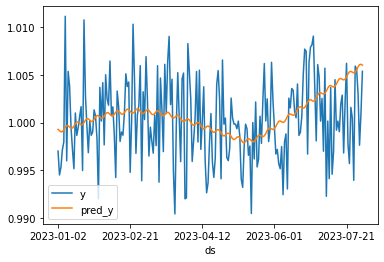

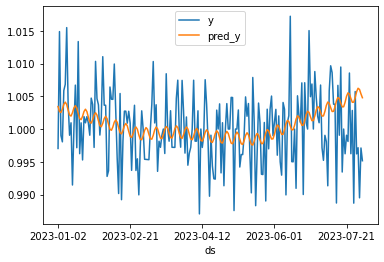

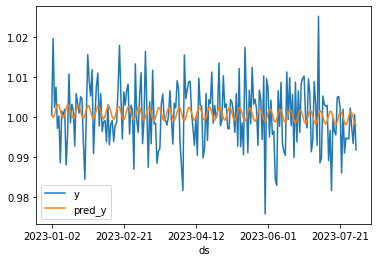

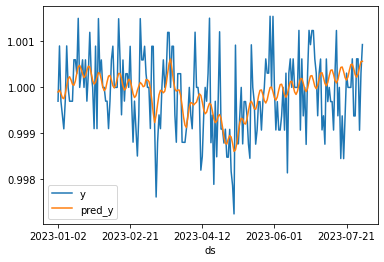

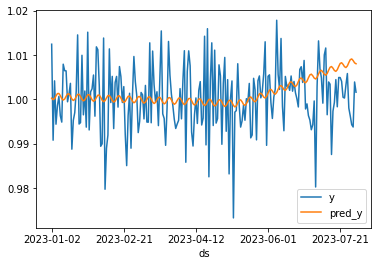

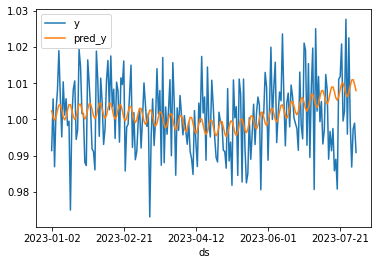

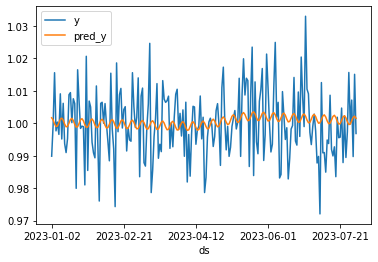

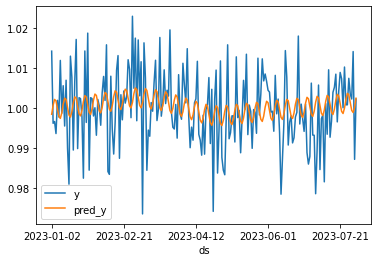

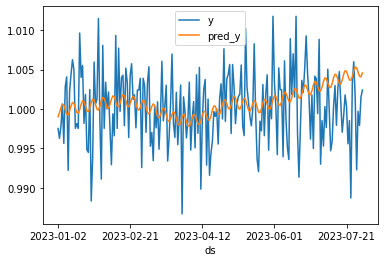

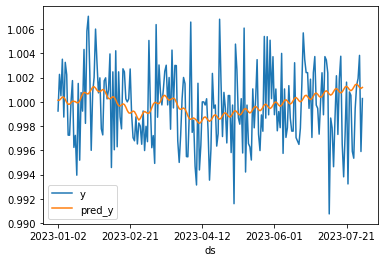

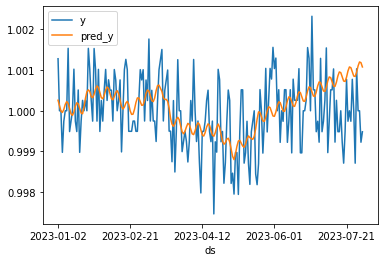

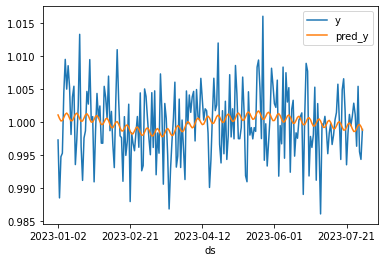

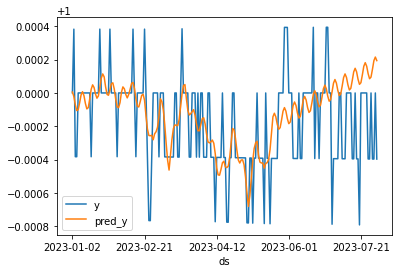

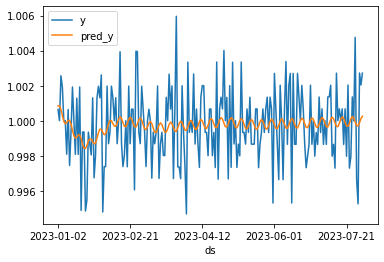

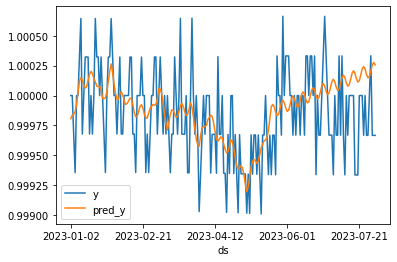

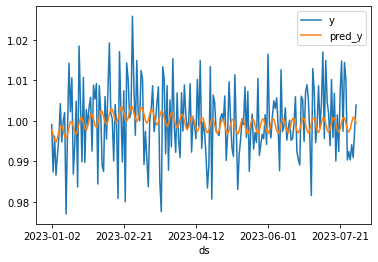

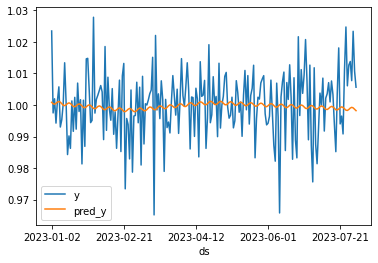

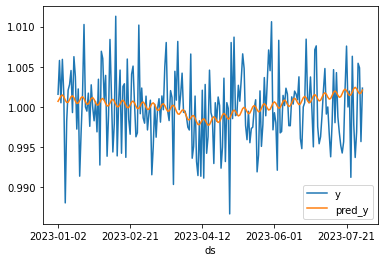

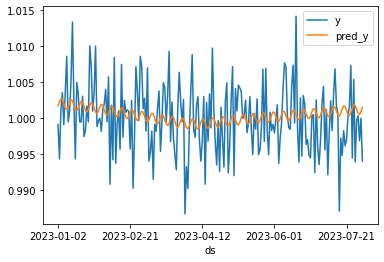

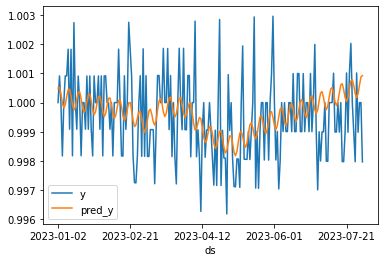

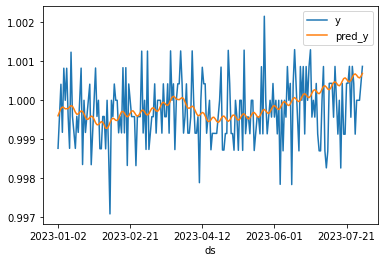

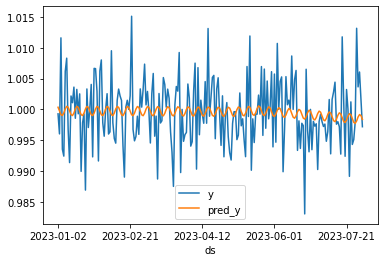

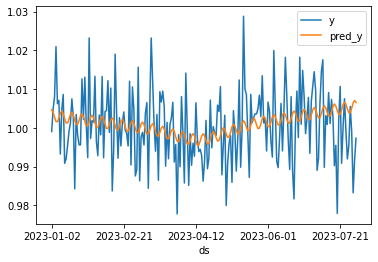

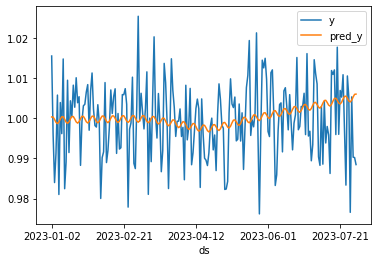

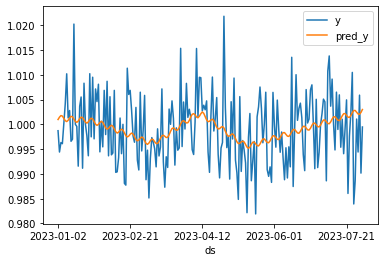

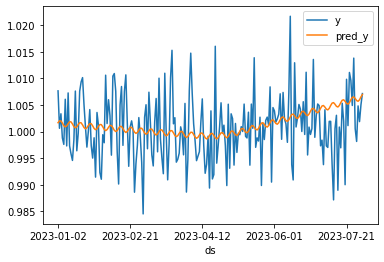

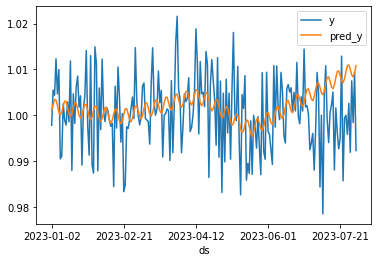

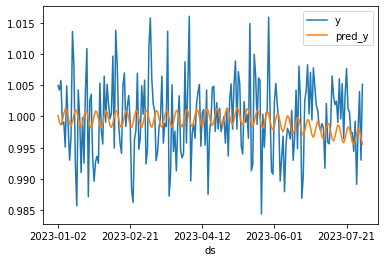

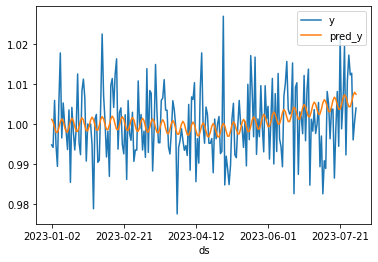

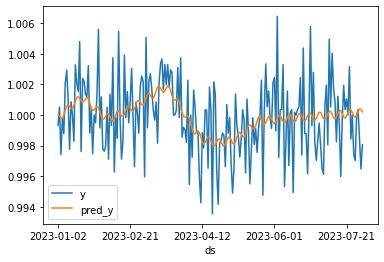

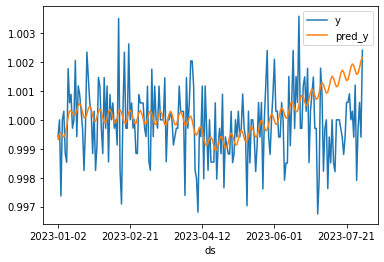

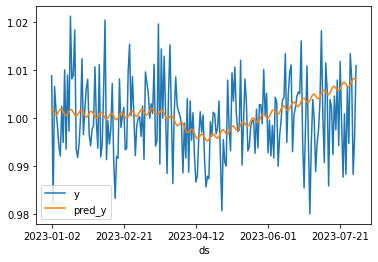

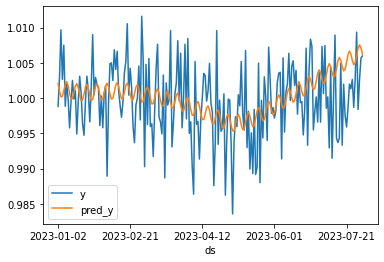

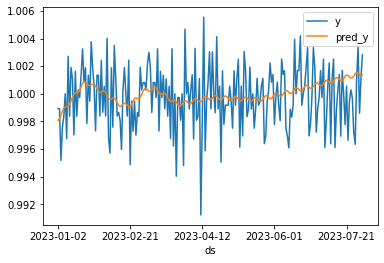

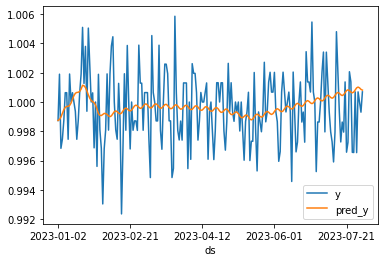

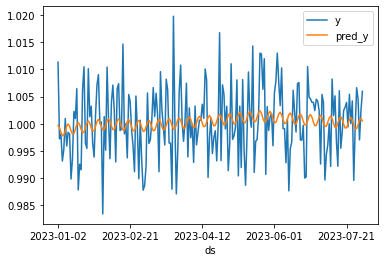

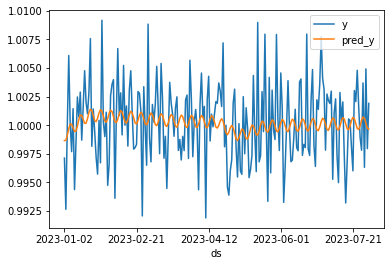

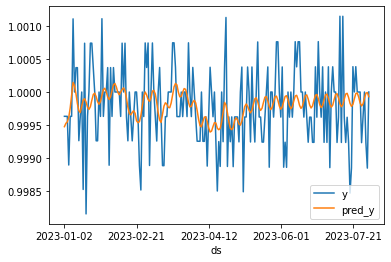

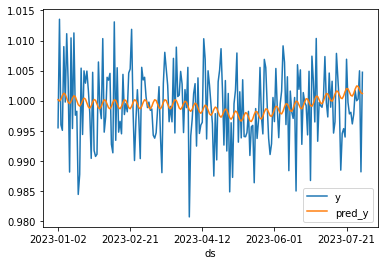

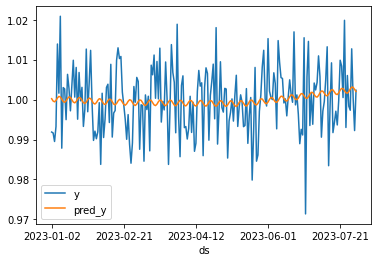

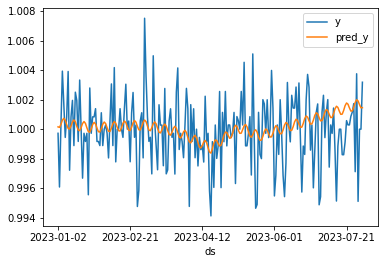

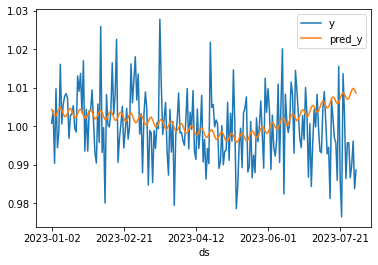

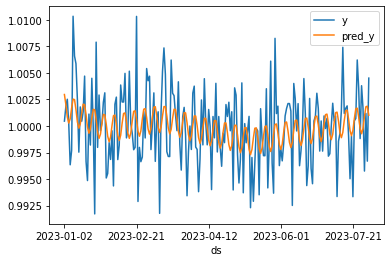

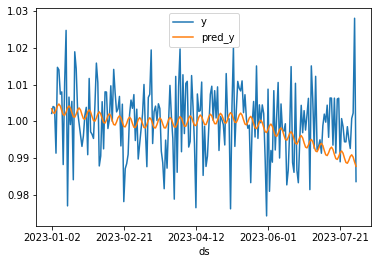

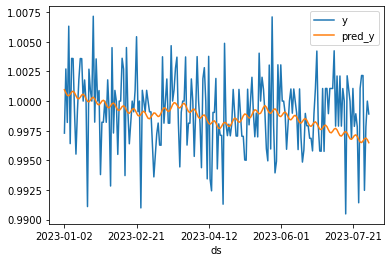

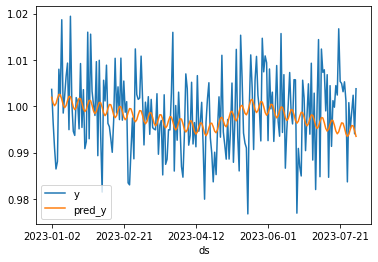

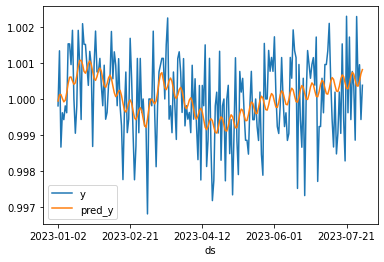

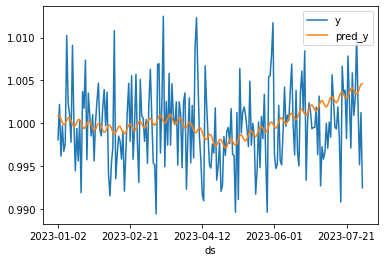

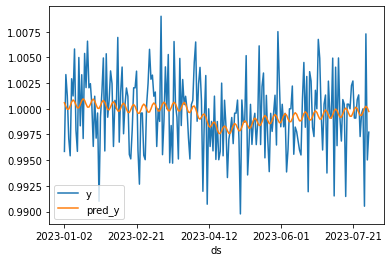

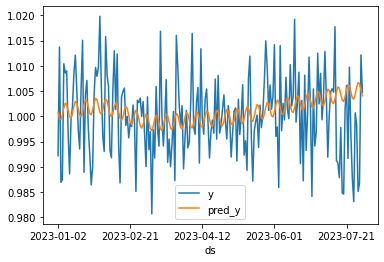

In [20]:
for stock, tmp_data in train_val_data.groupby('stock'):
    print('stock:', stock)
    tmp_data[['ds', 'y', 'pred_y']].plot(x='ds')